<div align="center">
  
# Analysis of Optimal Car Models

### CP321 Data Visualization

##### Torin Borton-McCallum - 190824620
##### Jasleen Pabla - xxxxxxxxx
##### Shakib Ahmed - xxxxxxxxx

</div>


#### Imports

---

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#### Load Data

---



In [71]:
cars_file = "MakeAndModel.TXT"
desc_file = "Descriptors.TXT"

In [48]:
cars = pd.read_csv(cars_file, delimiter='\t') #read file
cars = cars[cars['VEHICLE_CLASS'] == 'PASSENGER'] # take only passenger cars (no motorcycles, mopeds, etc)
cars = cars[cars['MAKE'] != '****'] # drop cars with unknown manufacturer
cars = cars.drop(columns=['VEHICLE_CLASS','OUT-OF-PROV', 'SOLD', 'SUSPENDED', 'TEMPORARY']) # remove unused columns
print(cars)

       MAKE MODEL  MODEL-YEAR  FIT-ACTIVE  FIT-INACTIVE  UNFIT  WRECKED  TOTAL
0      ACUR   ARL        2012           9             5      2        0     17
1      ACUR   ARL        2011           5             3      0        0      8
2      ACUR   ARL        2010          45            11      4        0     63
3      ACUR   ARL        2009          30            18      4        1     58
4      ACUR   ARL        2008          63            26      8        4    110
...     ...   ...         ...         ...           ...    ...      ...    ...
18504  WRKH   ***        2003           5             0      0        0      6
18505  WRKH   ***        2002           6             4      0        0     11
18506  WRKH   ***        2001           5             2      0        0      7
18507  WRKH   ***        2000           5             5      1        0     11
18508  WRKH   ***        1999           2             1      1        0      5

[18509 rows x 8 columns]


In [49]:
descriptors = pd.read_csv(desc_file, delimiter='\t') #read file
descriptors = descriptors[descriptors['VEHICLE_CLASS'] == 'PASSENGER'] # take only passenger cars (no motorcycles, mopeds, etc)
descriptors = descriptors.drop(columns=['VEHICLE_CLASS','OUT-OF-PROV', 'SOLD', 'SUSPENDED', 'TEMPORARY']) # remove unused columns

descriptors = descriptors[(descriptors['DESCRIPTOR'] != 'YEAR') & (descriptors['DESCRIPTOR'] != 'MOTIVE POWER')] #unused rows
descriptors = descriptors[(descriptors['VALUE'] != 'OTHER')& (descriptors['VALUE'] != 'MH')]


print(descriptors)

   DESCRIPTOR VALUE  FIT-ACTIVE  FIT-INACTIVE   UNFIT  WRECKED     TOTAL
0   CYLINDERS    00       71086          7117    1183       55     81630
1   CYLINDERS    02        1344          2239     627      506      5469
2   CYLINDERS    03       52111         35711    4119    16719    120649
3   CYLINDERS    04     4737227       4562834  809726  2520714  13729327
4   CYLINDERS    05       48825         60851   10650    27252    168939
5   CYLINDERS    06     2104183       4053307  539000  2180091   9807623
6   CYLINDERS    08      317904       2216657  328337   973554   4175725
7   CYLINDERS    10       11321         19153    2105     4832     42173
8   CYLINDERS    12        3578          5416    1189      362     12049
21  BODY TYPE    CV      126269         99275   20626    13004    298263
22  BODY TYPE    DB         110           356     161        6       665
24  BODY TYPE    SW       79020         22259    7365    12536    132211
25  BODY TYPE    SX         351           810     1

Optimal Manufacturing Year Range

---

In [79]:
# Group the filtered data by manufacturing year and calculate the percentages for each year
active_fit_percentage_by_year = (cars.groupby('MODEL-YEAR')['FIT-ACTIVE'].sum() /  # cars being driven
                                 cars.groupby('MODEL-YEAR')['TOTAL'].sum()) * 100
unfit_percentage_by_year = (cars.groupby('MODEL-YEAR')['UNFIT'].sum() / #cars not fit to drive but not wrecked
                            cars.groupby('MODEL-YEAR')['TOTAL'].sum()) * 100
wreck_percentage_by_year = (cars.groupby('MODEL-YEAR')['WRECKED'].sum() /
                            cars.groupby('MODEL-YEAR')['TOTAL'].sum()) * 100

# Create a DataFrame from the calculated percentages used to graph scatterplot
data = {'Manufacturing Year': active_fit_percentage_by_year.index,
        'Active Cars': active_fit_percentage_by_year.values,
        'Unfit Cars': unfit_percentage_by_year.values,
        'Wrecked Cars': wreck_percentage_by_year.values}
df = pd.DataFrame(data)

# Create the scatter plot using Plotly Express
fig = px.scatter(df, x='Manufacturing Year',
                 y=['Active Cars', 'Unfit Cars', 'Wrecked Cars'], #add df items to y axis
                 title='Percentage of Active Fit, Unfit, and Wrecked Cars vs. Manufacturing Year',
                 labels={'Manufacturing Year': 'Year', 'value': 'Percent', 'variable': 'Type'})

# Show the plot
fig.show()

#### Most Durable Manufacturers
---



In [80]:
new_cars = cars[cars['MODEL-YEAR'] >= 2010] #take only cars made 2010 or newer

# Group by 'MAKE' and sum 'FIT-ACTIVE' and 'TOTAL' values
active_cars = new_cars.groupby('MAKE')[['FIT-ACTIVE', 'TOTAL']].sum()

# Sort the DataFrame by the summed 'FIT-ACTIVE' percentages and add new column to df
active_cars['FIT-PERCENTAGE'] = (active_cars['FIT-ACTIVE'] / active_cars['TOTAL']) * 100

#take only brands with over 50000 cars to remove small companies
active_cars = active_cars[active_cars['TOTAL'] > 50000]

active_cars = active_cars.sort_values(by='FIT-PERCENTAGE', ascending=False)

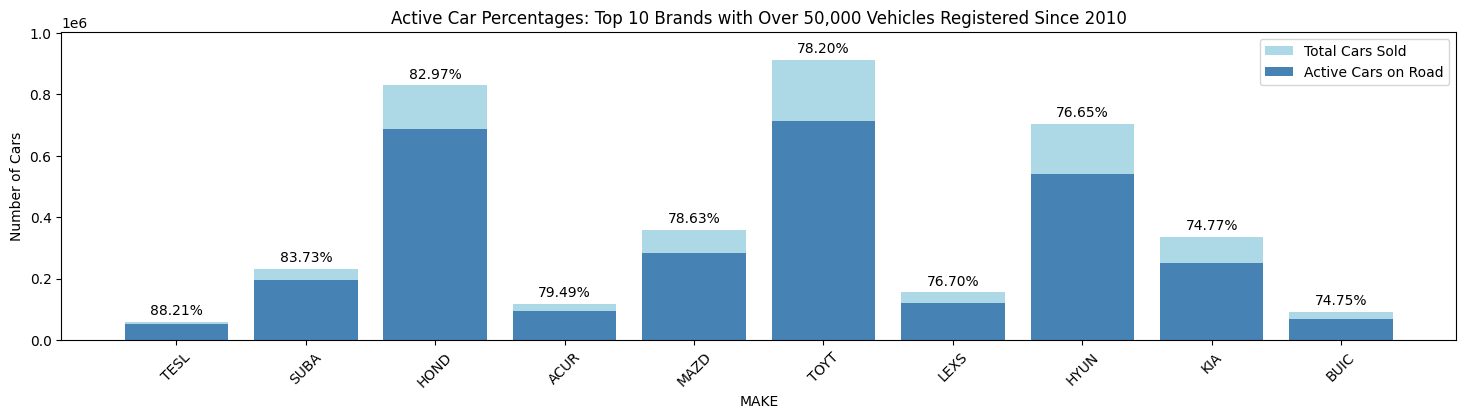

In [81]:
# Sort the DataFrame by the number of active cars and select only the top 10
top10 = active_cars.nlargest(10, 'FIT-PERCENTAGE')

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(18, 4))
bars = ax.bar(top10.index, top10['TOTAL'], color='lightblue', label='Total Cars Sold')
ax.bar(top10.index, top10['FIT-ACTIVE'], color='steelblue', label='Active Cars on Road')
ax.set_xlabel('MAKE')
ax.set_ylabel('Number of Cars')
ax.set_title('Active Car Percentages: Top 10 Brands with Over 50,000 Vehicles Registered Since 2010')
ax.tick_params(axis='x', rotation=45)

# Annotate each bar with the percentage value
for bar, percentage in zip(bars, top10['FIT-PERCENTAGE']):
    height = bar.get_height()
    ax.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Set y-axis limits with extra space above the largest bar
largest_bar_height = max(top10['TOTAL'])
ax.set_ylim(top=largest_bar_height * 1.1)  # Increase by 10% above the largest bar height to avoid overlap

# Move legend to the top right corner
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# Display the plot
plt.show()

#### Popular Car Makes
---



In [85]:
# adjust cars df to only account for the top 10 car brands we found above
makes_list = top10.index.tolist()
top_cars = cars[cars['MAKE'].isin(makes_list)] #filter only cars in top list
top_cars = top_cars[top_cars['MODEL'] != '***']#drop unknown data
print(top_cars)

       MAKE MODEL  MODEL-YEAR  FIT-ACTIVE  FIT-INACTIVE  UNFIT  WRECKED  TOTAL
0      ACUR   ARL        2012           9             5      2        0     17
1      ACUR   ARL        2011           5             3      0        0      8
2      ACUR   ARL        2010          45            11      4        0     63
3      ACUR   ARL        2009          30            18      4        1     58
4      ACUR   ARL        2008          63            26      8        4    110
...     ...   ...         ...         ...           ...    ...      ...    ...
17099  TOYT   YSE        2016         785            82     68        7   1104
17100  TOYT   4WL        2023           9             0      0        0      9
17101  TOYT   4WL        2022         915            25      3        0    944
17102  TOYT   5WL        2023          32             0      0        0     32
17103  TOYT   5WL        2022         816            11      3        0    831

[3845 rows x 8 columns]


In [55]:
# Filter top_cars to include only 'FIT-Active' cars
fit_active_cars = top_cars[top_cars['FIT-ACTIVE'] > 0]

# Group the data by both 'MAKE' and 'MODEL' and sum the 'FIT-ACTIVE' values
grouped_cars = fit_active_cars.groupby(['MAKE', 'MODEL'])['FIT-ACTIVE'].sum().reset_index()

# Sort the data within each 'MAKE' group by 'FIT-ACTIVE' values in descending order
grouped_cars_sorted = grouped_cars.groupby('MAKE').apply(lambda x: x.nlargest(5, 'FIT-ACTIVE')).reset_index(drop=True)

# Create the treemap for total 'FIT-ACTIVE' Civics for each make
fig = px.treemap(grouped_cars_sorted,
                 path=['MAKE', 'MODEL'],
                 values='FIT-ACTIVE',
                 title='Top 5 Most Popular Active Car Models Across Manufacturers')
fig.show()


In [70]:
top5 = grouped_cars_sorted.drop(columns=['FIT-ACTIVE'])

#### Optimal Car Features

---



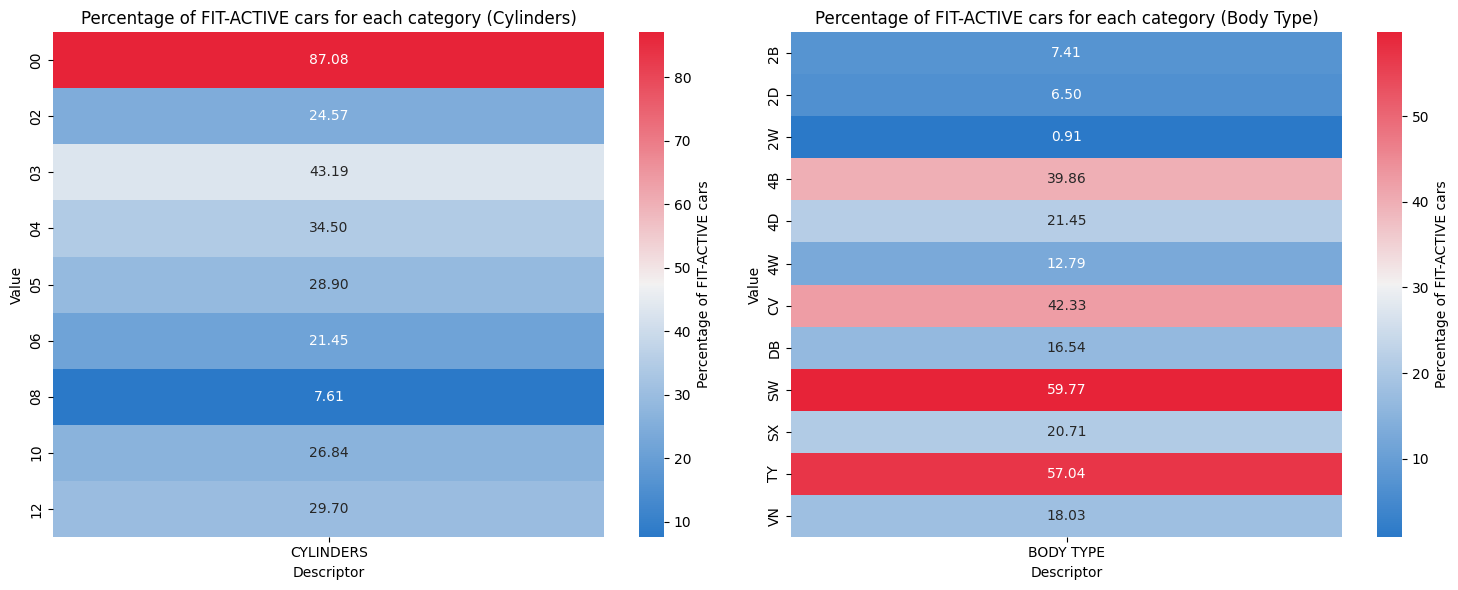

In [44]:
# Filter descriptors for cylinders
cylinders_descriptors = descriptors[descriptors['DESCRIPTOR'] == 'CYLINDERS'].copy()

# Calculate the percentage of FIT-ACTIVE cars for each category in cylinders
percentage_fit_active_cylinders = (cylinders_descriptors['FIT-ACTIVE'] / cylinders_descriptors['TOTAL']) * 100

# Add the calculated percentages as a new column using .loc
cylinders_descriptors.loc[:, 'FIT-ACTIVE_PERCENTAGE'] = percentage_fit_active_cylinders

# Pivot the DataFrame for plotting
heatmap_data_cylinders = cylinders_descriptors.pivot(index='VALUE', columns='DESCRIPTOR', values='FIT-ACTIVE_PERCENTAGE')

# Filter descriptors for body type
body_type_descriptors = descriptors[descriptors['DESCRIPTOR'] == 'BODY TYPE'].copy()

# Calculate the percentage of FIT-ACTIVE cars for each category in body type
percentage_fit_active_body_type = (body_type_descriptors['FIT-ACTIVE'] / body_type_descriptors['TOTAL']) * 100

# Add the calculated percentages as a new column using .loc
body_type_descriptors.loc[:, 'FIT-ACTIVE_PERCENTAGE'] = percentage_fit_active_body_type

# Pivot the DataFrame for plotting
heatmap_data_body_type = body_type_descriptors.pivot(index='VALUE', columns='DESCRIPTOR', values='FIT-ACTIVE_PERCENTAGE')

# Define custom color map
custom_cmap = sns.diverging_palette(250, 10, s=90, l=50, as_cmap=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the heatmap for cylinders
sns.heatmap(heatmap_data_cylinders, cmap=custom_cmap, annot=True, fmt=".2f", cbar_kws={'label': 'Percentage of FIT-ACTIVE cars'}, ax=axes[0])
axes[0].set_title('Percentage of FIT-ACTIVE cars for each category (Cylinders)')
axes[0].set_xlabel('Descriptor')
axes[0].set_ylabel('Value')

# Plot the heatmap for body type
sns.heatmap(heatmap_data_body_type, cmap=custom_cmap, annot=True, fmt=".2f", cbar_kws={'label': 'Percentage of FIT-ACTIVE cars'}, ax=axes[1])
axes[1].set_title('Percentage of FIT-ACTIVE cars for each category (Body Type)')
axes[1].set_xlabel('Descriptor')
axes[1].set_ylabel('Value')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [66]:
top_cylinders = cylinders_descriptors.sort_values(by='FIT-ACTIVE_PERCENTAGE', ascending=False).head(5)
top_body_types = body_type_descriptors.sort_values(by='FIT-ACTIVE_PERCENTAGE', ascending=False).head(5)
print(top_cylinders)
print(top_body_types)

  DESCRIPTOR VALUE  FIT-ACTIVE  FIT-INACTIVE   UNFIT  WRECKED     TOTAL  \
0  CYLINDERS    00       71086          7117    1183       55     81630   
2  CYLINDERS    03       52111         35711    4119    16719    120649   
3  CYLINDERS    04     4737227       4562834  809726  2520714  13729327   
8  CYLINDERS    12        3578          5416    1189      362     12049   
4  CYLINDERS    05       48825         60851   10650    27252    168939   

   FIT-ACTIVE_PERCENTAGE  
0              87.083180  
2              43.192235  
3              34.504437  
8              29.695410  
4              28.900964  
   DESCRIPTOR VALUE  FIT-ACTIVE  FIT-INACTIVE   UNFIT  WRECKED     TOTAL  \
24  BODY TYPE    SW       79020         22259    7365    12536    132211   
26  BODY TYPE    TY     3277156       1475538  273127   295774   5745372   
21  BODY TYPE    CV      126269         99275   20626    13004    298263   
31  BODY TYPE    4B      536979        399609   77878   219609   1347115   
32  BOD